In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [2]:
pip install imbalanced-learn

In [3]:
from google.colab import drive
import os
import pandas as pd
from tqdm import tqdm

# Force remount Google Drive
drive.mount('/content/drive', force_remount=True)

# Initialize lists to store image paths and labels
images = []
labels = []

# Path to the dataset in your Google Drive
base_path = '/content/drive/My Drive/Kaggle_dataset/Alzheimer_dataset'

# Iterate through subfolders in the dataset
try:
    for subfolder in tqdm(os.listdir(base_path), desc='Processing subfolders'):
        subfolder_path = os.path.join(base_path, subfolder)
        # Check if subfolder_path is a directory
        if os.path.isdir(subfolder_path):
            # Iterate through image files in each subfolder
            for image_filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
except KeyboardInterrupt:
    print("Process interrupted manually.")
except Exception as e:
    print(f"Error processing files: {e}")

# Create a DataFrame from the collected image paths and labels
df = pd.DataFrame({'image': images, 'label': labels})

# Verify the DataFrame
print(df.head())


Mounted at /content/drive


Processing subfolders: 100%|██████████| 5/5 [00:28<00:00,  5.66s/it]

                                               image               label
0  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia
1  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia
2  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia
3  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia
4  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia


In [4]:
print(df.head())


                                               image               label
0  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia
1  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia
2  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia
3  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia
4  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Very mild Dementia


<ipython-input-5-828b37f0494f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label, palette='Set1')


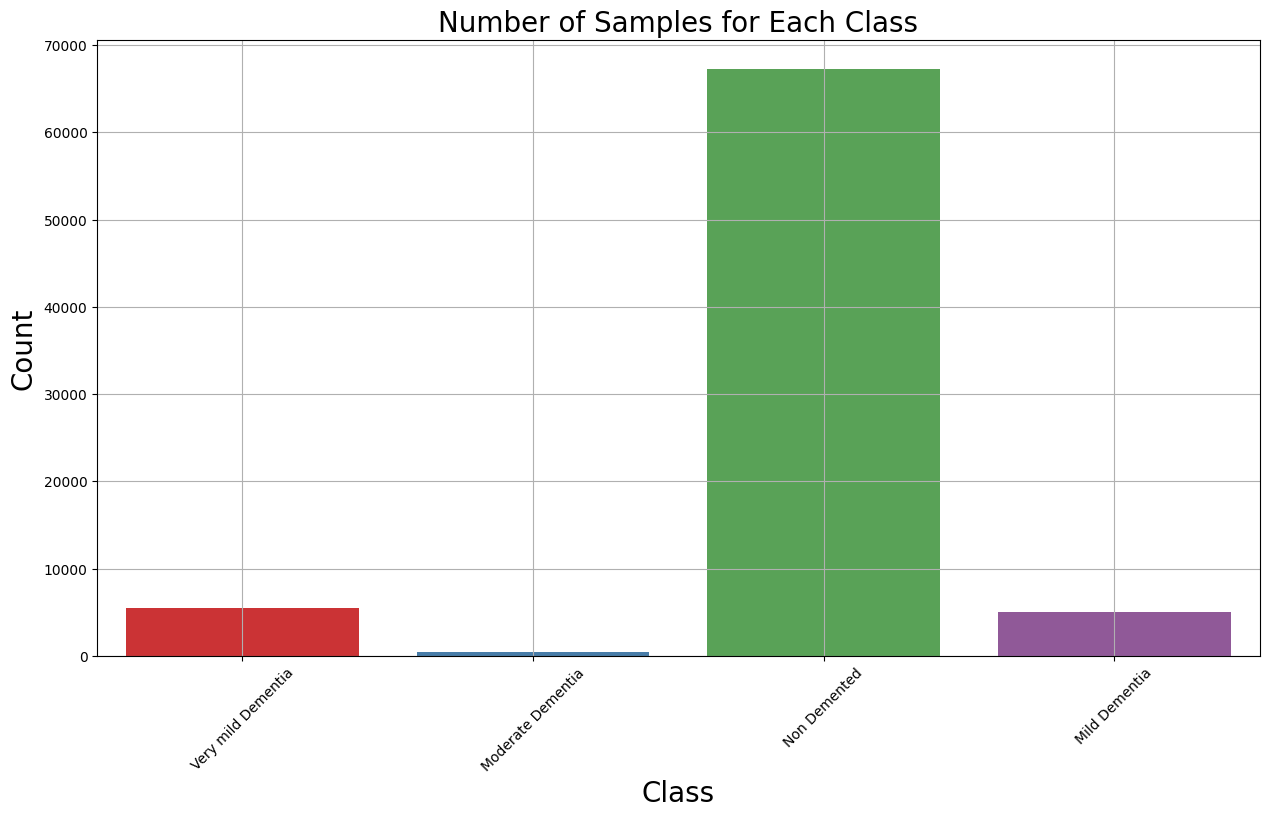

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
ax = sns.countplot(x=df.label, palette='Set1')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('Number of Samples for Each Class', fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [6]:
# Determine the desired number of samples, for example, 10% of the dataset
desired_sample_size = 500  # Adjust this value as needed

# Randomly sample the desired number of images
reduced_df = df.sample(n=desired_sample_size, random_state=42)

# Verify the reduced DataFrame
print(reduced_df.shape)
print(reduced_df.head())

# Create a data generator using the reduced DataFrame
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
Size = (176, 176)
batch_size = 6500  # Adjust as necessary

# Create an ImageDataGenerator instance
work_dr = ImageDataGenerator(rescale=1./255)

# Use flow_from_dataframe on the reduced DataFrame
train_data_gen = work_dr.flow_from_dataframe(
    reduced_df,
    x_col='image',
    y_col='label',
    target_size=Size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' if you have multiple classes
    shuffle=True  # Set to True if you want to shuffle the data
)

# Generate a batch of data
train_data, train_labels = train_data_gen.next()

# Verify the shapes of the generated data
print(train_data.shape)
print(train_labels.shape)


(500, 2)
                                                   image         label
20716  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Non Demented
22882  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Non Demented
53548  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Non Demented
72630  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Non Demented
72271  /content/drive/My Drive/Kaggle_dataset/Alzheim...  Non Demented
Found 500 validated image filenames belonging to 4 classes.
(500, 176, 176, 3)
(500, 4)


In [7]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [8]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(1724, 176, 176, 3) (1724, 4)


<ipython-input-9-671c5a574679>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels,palette='Set1')


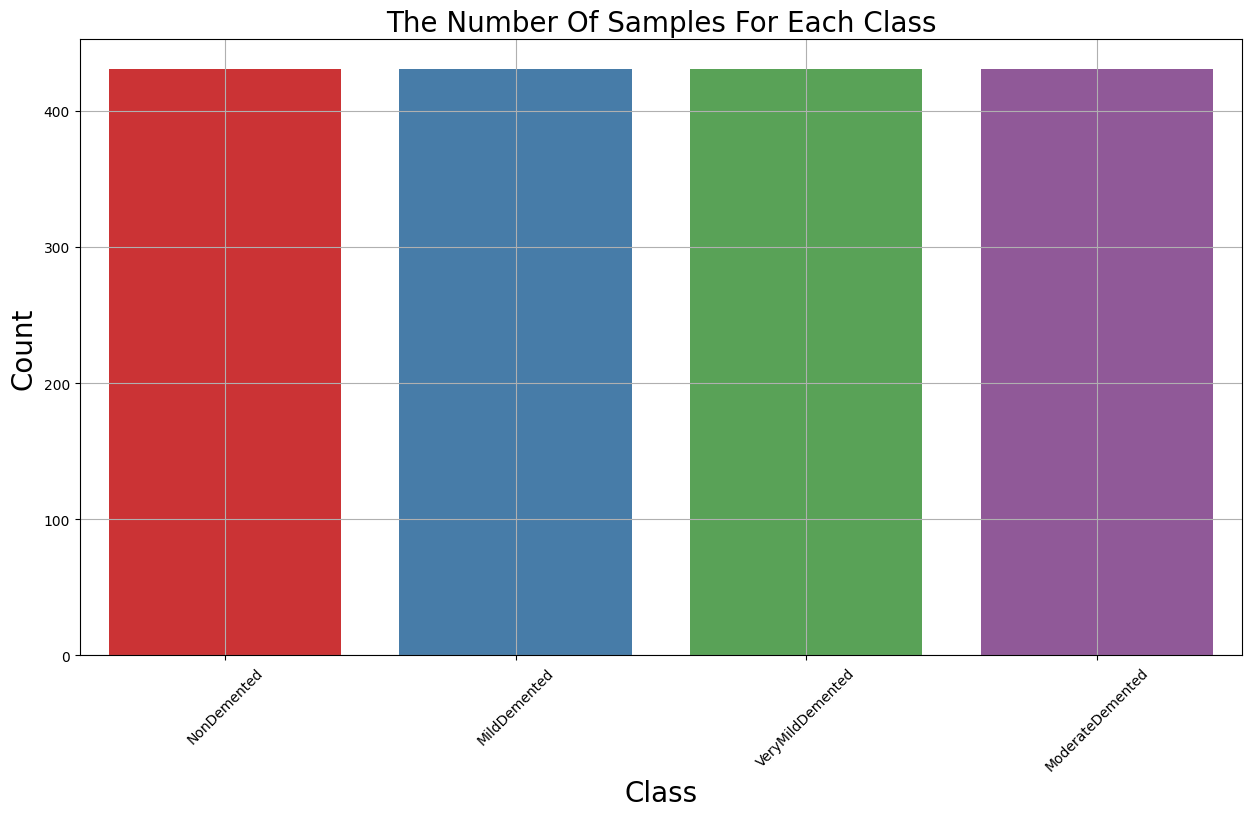

In [9]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [10]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (1206, 176, 176, 3)
X_test shape is  (259, 176, 176, 3)
X_val shape is  (259, 176, 176, 3)
y_train shape is  (1206, 4)
y_test shape is  (259, 4)
y_val shape is  (259, 4)


In [11]:
base_model = tf.keras.applications.InceptionV3(input_shape=(176,176,3),include_top=False,weights='imagenet')
base_model.trainable = False
model_Inception=keras.models.Sequential()
model_Inception.add(base_model)
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.GlobalAveragePooling2D())
model_Inception.add(keras.layers.Flatten())
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(512,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(256,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(128,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(64,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(4, activation=tf.nn.softmax))
model_Inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)               1

In [12]:
!pip install graphviz pydot

In [13]:
!pip install pydot

In [14]:
!pip install graphviz

In [15]:
pip install pydot


In [16]:
checkpoint_cb =ModelCheckpoint("model_Inception.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model_Inception.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model_Inception.fit(X_train,y_train, epochs=20, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 1.5945 - accuracy: 0.3574

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 135s 3s/step - loss: 1.5945 - accuracy: 0.3574 - val_loss: 1.0370 - val_accuracy: 0.5174
Epoch 2/20
38/38 [==============================] - 107s 3s/step - loss: 1.1915 - accuracy: 0.4925 - val_loss: 0.8188 - val_accuracy: 0.6834
Epoch 3/20
38/38 [==============================] - 102s 3s/step - loss: 0.9614 - accuracy: 0.5954 - val_loss: 0.6205 - val_accuracy: 0.7876
Epoch 4/20
38/38 [==============================] - 108s 3s/step - loss: 0.8444 - accuracy: 0.6534 - val_loss: 0.4736 - val_accuracy: 0.8069
Epoch 5/20
38/38 [==============================] - 107s 3s/step - loss: 0.7044 - accuracy: 0.7156 - val_loss: 0.3862 - val_accuracy: 0.8687
Epoch 6/20
38/38 [==============================] - 104s 3s/step - loss: 0.5854 - accuracy: 0.7769 - val_loss: 0.3348 - val_accuracy: 0.8687
Epoch 7/20
38/38 [==============================] - 108s 3s/step - loss: 0.5137 - accuracy: 0.8093 - val_loss: 0.2967 - val_accuracy: 0.8880
Epoch 8/20
38/38 [======

In [17]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0   1.594525  0.357380  1.037005      0.517375
1   1.191537  0.492537  0.818757      0.683398
2   0.961446  0.595357  0.620533      0.787645
3   0.844380  0.653400  0.473557      0.806950
4   0.704436  0.715589  0.386186      0.868726
5   0.585392  0.776949  0.334781      0.868726
6   0.513734  0.809287  0.296672      0.888031
7   0.439915  0.835821  0.259036      0.915058
8   0.380894  0.869818  0.199521      0.930502
9   0.306338  0.898010  0.177874      0.934363
10  0.284755  0.903814  0.162854      0.945946
11  0.243663  0.920398  0.140464      0.945946
12  0.235433  0.924544  0.122454      0.961390
13  0.235610  0.916252  0.126679      0.957529
14  0.205596  0.935323  0.111137      0.961390
15  0.166473  0.951078  0.114859      0.976834
16  0.163247  0.949420  0.086318      0.957529
17  0.148917  0.956053  0.077058      0.969112
18  0.169647  0.946103  0.061784      0.980695
19  0.141187  0.956882  0.063805      0.980695

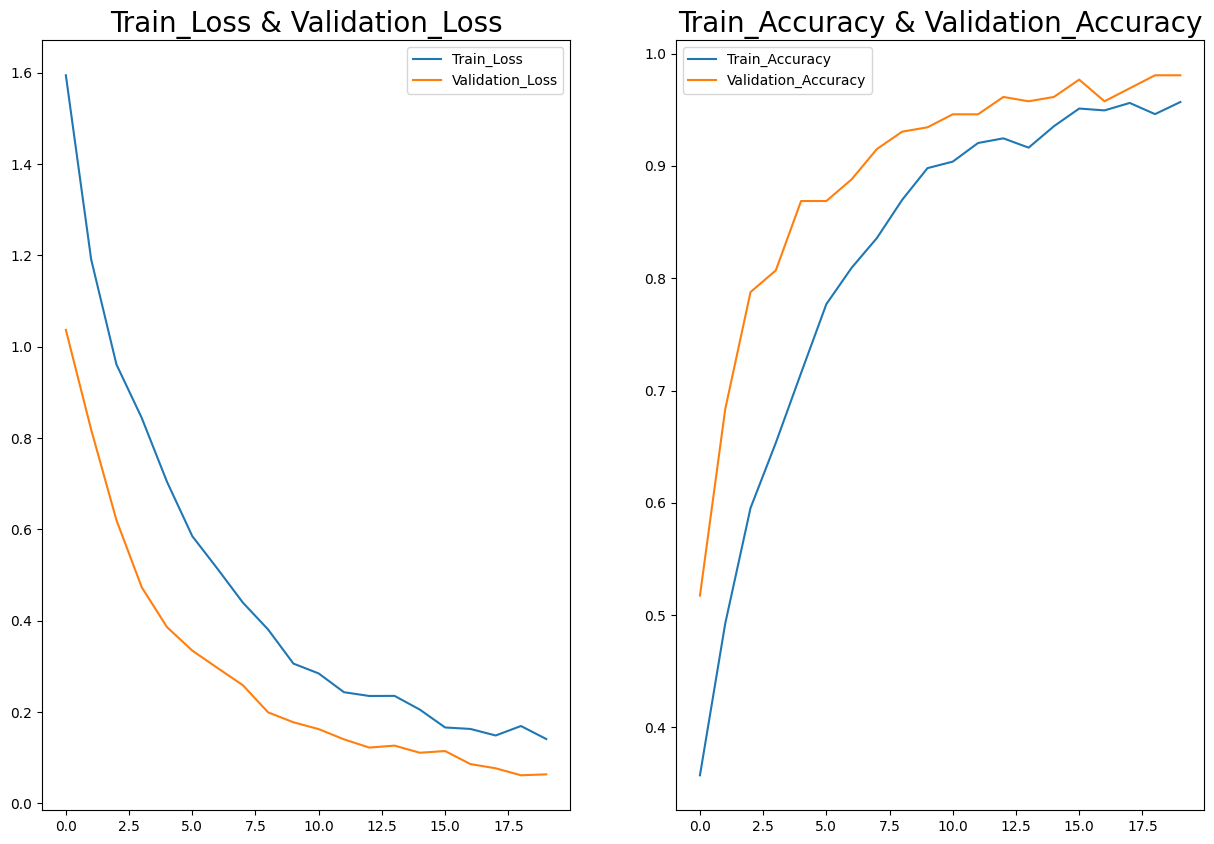

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [19]:
score, acc= model_Inception.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

9/9 [==============================] - 32s 3s/step - loss: 0.1340 - accuracy: 0.9614
Test Loss = 0.13404077291488647
Test Accuracy = 0.96138995885849


In [20]:
predictions = model_Inception.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

9/9 [==============================] - 22s 2s/step


Actual  Prediction
0         0           0
1         3           3
2         1           1
3         2           2
4         1           1
..      ...         ...
254       1           1
255       3           3
256       3           3
257       2           2
258       2           2

[259 rows x 2 columns]

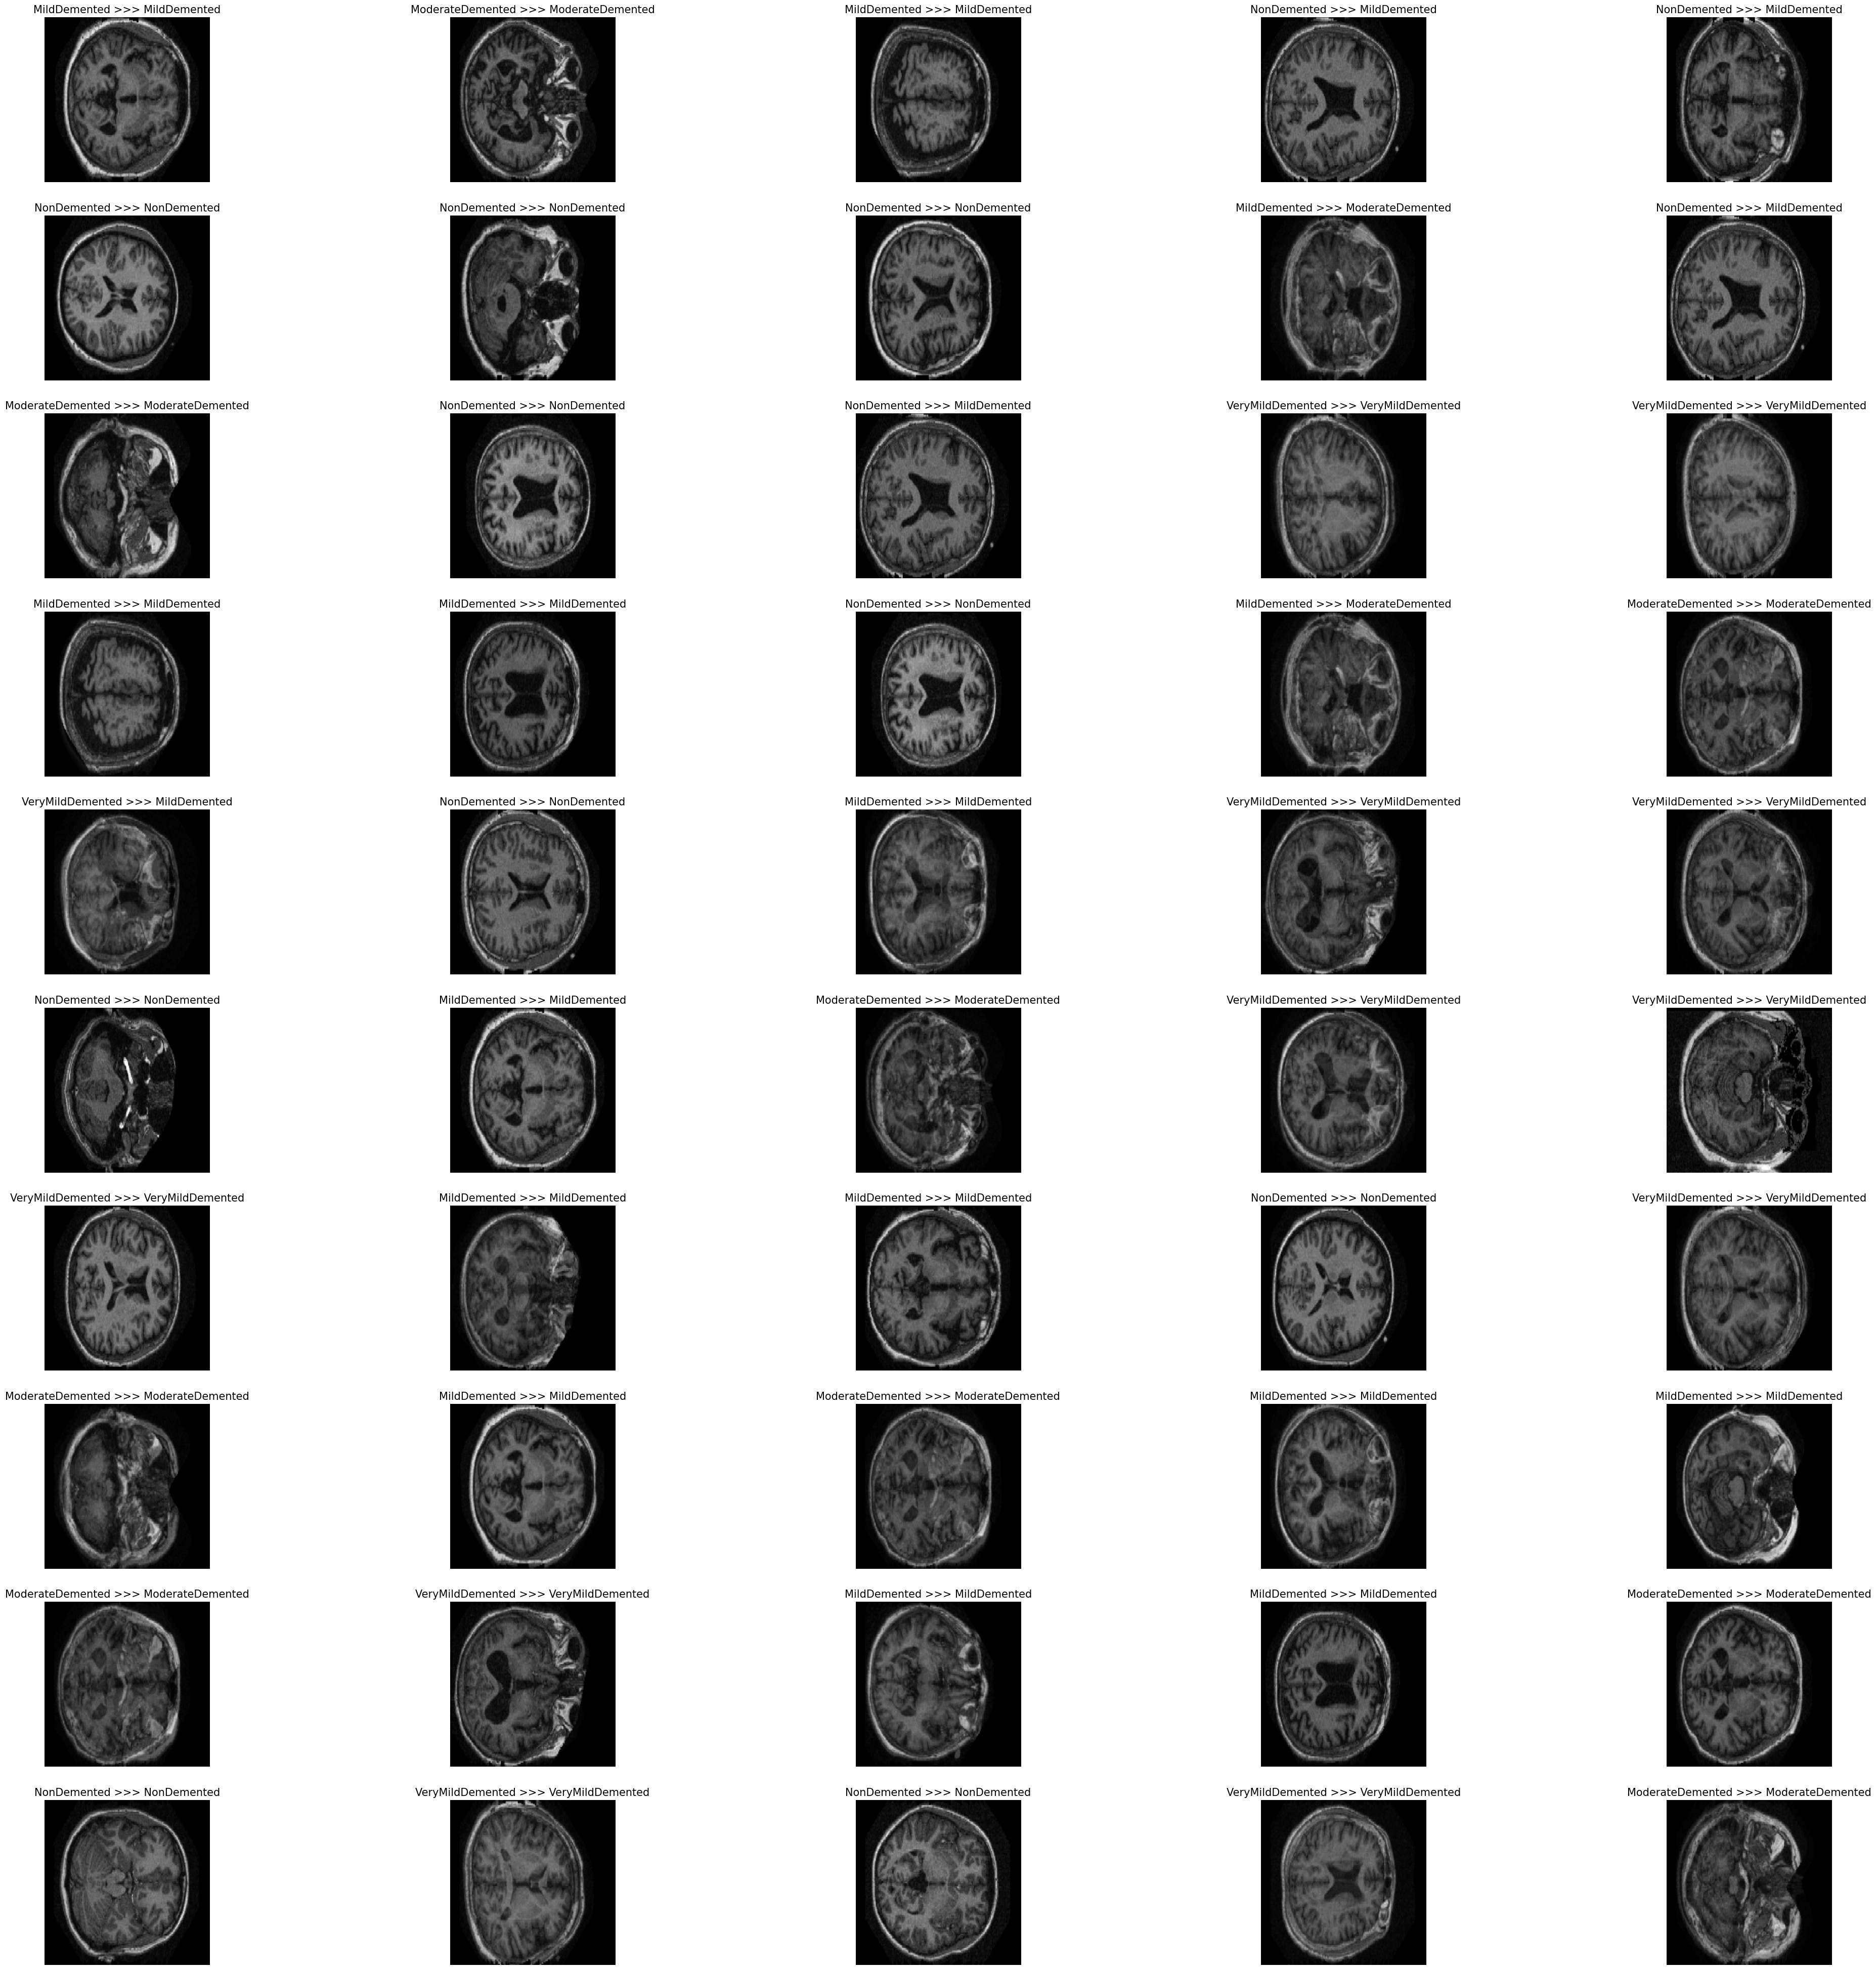

In [21]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)

array([[61,  1,  2,  0],
       [ 0, 65,  0,  0],
       [ 4,  0, 60,  1],
       [ 1,  0,  1, 63]])

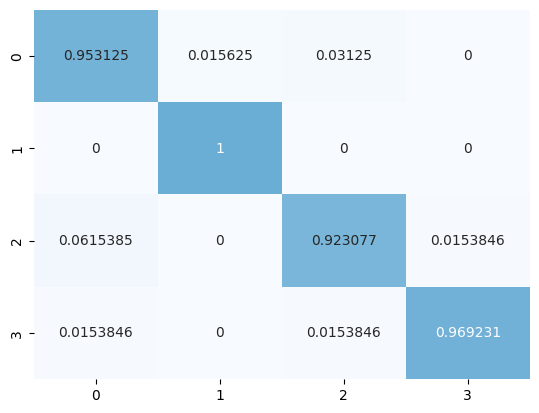

In [22]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [23]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.92      0.95      0.94        64
           1       0.98      1.00      0.99        65
           2       0.95      0.92      0.94        65
           3       0.98      0.97      0.98        65

    accuracy                           0.96       259
   macro avg       0.96      0.96      0.96       259
weighted avg       0.96      0.96      0.96       259



In [24]:
!pip install tensorflow-privacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.23.0
    Uninstalling tensorflow-probability-0.23.0:
      Successfully uninstalled tensorflow-probability-0.23.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [26]:
import tensorflow as tf
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer
from sklearn.metrics import f1_score, recall_score, precision_score

# Define differential privacy parameters
noise_multiplier = 1.1  # This controls the amount of noise added for privacy
l2_norm_clip = 1.0  # This clips the gradients to this norm
microbatches = 1  # Number of microbatches for each gradient update
batch_size = 32

# Ensure the total batch size is divisible by the number of microbatches
assert batch_size % microbatches == 0, "Batch size must be divisible by the number of microbatches"

# Create a differentially private optimizer
dp_optimizer = DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=microbatches
)

# Define callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_Inception.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Compile the model with the differentially private optimizer
model_Inception.compile(optimizer=dp_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the number of clients
num_clients = 3

# Split the training data into three portions for each client
client_data = np.array_split(X_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

# Initialize lists to store evaluation metrics for each client
f1_scores = []
recall_scores = []
precision_scores = []

# Train the model on each client's data separately
for i in range(num_clients):
    print(f"Training on client {i + 1}/{num_clients}")
    # Train the model
    hist = model_Inception.fit(
        client_data[i], client_labels[i],
        epochs=20,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # Evaluate the model
    score = model_Inception.evaluate(X_test, y_test)

    # Predict labels
    y_pred = model_Inception.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate F1 score, recall, and precision
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='macro')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='macro')
    precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='macro')

    # Append scores to lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)

# Print the evaluation metrics for each client
for i in range(num_clients):
    print(f"Client {i + 1} Evaluation Metrics:")
    print(f"F1 Score: {f1_scores[i]}")
    print(f"Recall: {recall_scores[i]}")
    print(f"Precision: {precision_scores[i]}")


Training on client 1/3
Epoch 1/20
13/13 [==============================] - 69s 4s/step - loss: 0.1056 - accuracy: 0.9701 - val_loss: 0.0668 - val_accuracy: 0.9807
Epoch 2/20
13/13 [==============================] - 52s 4s/step - loss: 0.1025 - accuracy: 0.9602 - val_loss: 0.0655 - val_accuracy: 0.9807
Epoch 3/20
13/13 [==============================] - 51s 4s/step - loss: 0.1142 - accuracy: 0.9627 - val_loss: 0.0651 - val_accuracy: 0.9768
Epoch 4/20
13/13 [==============================] - 45s 4s/step - loss: 0.0871 - accuracy: 0.9751 - val_loss: 0.0658 - val_accuracy: 0.9768
Epoch 5/20
13/13 [==============================] - 50s 4s/step - loss: 0.1057 - accuracy: 0.9652 - val_loss: 0.0647 - val_accuracy: 0.9807
Epoch 6/20
13/13 [==============================] - 49s 4s/step - loss: 0.1096 - accuracy: 0.9701 - val_loss: 0.0650 - val_accuracy: 0.9807
Epoch 7/20
13/13 [==============================] - 49s 4s/step - loss: 0.1064 - accuracy: 0.9801 - val_loss: 0.0660 - val_accuracy: 0.98

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 48s 4s/step - loss: 0.1272 - accuracy: 0.9652 - val_loss: 0.0647 - val_accuracy: 0.9768
Epoch 5/20
13/13 [==============================] - 49s 4s/step - loss: 0.1024 - accuracy: 0.9701 - val_loss: 0.0643 - val_accuracy: 0.9768
Epoch 6/20
13/13 [==============================] - 49s 4s/step - loss: 0.1335 - accuracy: 0.9502 - val_loss: 0.0648 - val_accuracy: 0.9768
Epoch 7/20
13/13 [==============================] - 48s 4s/step - loss: 0.1141 - accuracy: 0.9602 - val_loss: 0.0661 - val_accuracy: 0.9768
Epoch 8/20
13/13 [==============================] - 45s 4s/step - loss: 0.1135 - accuracy: 0.9602 - val_loss: 0.0659 - val_accuracy: 0.9768
Epoch 9/20
13/13 [==============================] - 48s 4s/step - loss: 0.1111 - accuracy: 0.9577 - val_loss: 0.0664 - val_accuracy: 0.9768
Epoch 10/20
13/13 [==============================] - 50s 4s/step - loss: 0.1662 - accuracy: 0.9378 - val_loss: 0.0666 - val_accuracy: 0.9768
Epoch 11/20
13/13 [===========

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib
from sklearn.metrics import f1_score, recall_score, precision_score

# Define differential privacy parameters
noise_multiplier = 1.1  # This controls the amount of noise added for privacy
l2_norm_clip = 1.0  # This clips the gradients to this norm
microbatches = 1  # Number of microbatches for each gradient update
batch_size = 32

# Define the number of clients
num_clients = 3

# Split the training data into three portions for each client
client_data = np.array_split(X_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

# Initialize lists to store evaluation metrics for each client
f1_scores = []
recall_scores = []
precision_scores = []

# Define model architecture
def create_model():
    # Define your model architecture here
    pass

# Define callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_Inception.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Initialize the global model
global_model = create_model()

# Train the model on each client's data separately
for i in range(num_clients):
    print(f"Training on client {i + 1}/{num_clients}")
    # Create a new model for each client
    client_model = create_model()

    # Set the global model weights to the client model
    client_model.set_weights(global_model.get_weights())

    # Compile the client model
    client_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the client model
    client_model.fit(
        client_data[i], client_labels[i],
        epochs=20,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # Evaluate the client model
    score = client_model.evaluate(X_test, y_test)

    # Predict labels
    y_pred = client_model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate F1 score, recall, and precision
    f1 = f1_score(y_test, y_pred_labels, average='macro')
    recall = recall_score(y_test, y_pred_labels, average='macro')
    precision = precision_score(y_test, y_pred_labels, average='macro')

    # Append scores to lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)

# Federated Averaging: Average the weights
new_weights = []
for layer_weights in zip(*[client_model.get_weights() for client_model in client_models]):
    new_weights.append(np.mean(layer_weights, axis=0))

# Set the averaged weights to the global model
global_model.set_weights(new_weights)

# Compute epsilon
epsilon, _ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
    n=len(X_train),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=20 * num_clients,  # Total epochs across all clients
    delta=1e-5
)

print("Privacy Budget (Epsilon):", epsilon)

# Print the evaluation metrics for each client
for i in range(num_clients):
    print(f"Client {i + 1} Evaluation Metrics:")
    print(f"F1 Score: {f1_scores[i]}")
    print(f"Recall: {recall_scores[i]}")
    print(f"Precision: {precision_scores[i]}")


In [35]:
import tensorflow as tf
import numpy as np
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

# Define differential privacy parameters
noise_multiplier = 1.1  # This controls the amount of noise added for privacy
l2_norm_clip = 1.0  # This clips the gradients to this norm
microbatches = 1  # Number of microbatches for each gradient update
batch_size = 32

# Define the number of clients
num_clients = 3

# Split the training data into three portions for each client
client_data = np.array_split(X_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

# Initialize lists to store evaluation metrics for each client
f1_scores = []
recall_scores = []
precision_scores = []

# Train the model on each client's data separately
for i in range(num_clients):
    print(f"Training on client {i + 1}/{num_clients}")
    # Train the model
    hist = model_Inception.fit(
        client_data[i], client_labels[i],
        epochs=20,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_cb, early_stopping_cb]
    )

    # Evaluate the model
    score = model_Inception.evaluate(X_test, y_test)

    # Predict labels
    y_pred = model_Inception.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate F1 score, recall, and precision
    f1 = f1_score(np.argmax(y_test, axis=1), y_pred_labels, average='macro')
    recall = recall_score(np.argmax(y_test, axis=1), y_pred_labels, average='macro')
    precision = precision_score(np.argmax(y_test, axis=1), y_pred_labels, average='macro')

    # Append scores to lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)

# Print the evaluation metrics for each client
for i in range(num_clients):
    print(f"Client {i + 1} Evaluation Metrics:")
    print(f"F1 Score: {f1_scores[i]}")
    print(f"Recall: {recall_scores[i]}")
    print(f"Precision: {precision_scores[i]}")

# Compute epsilon
epsilon, _ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
    n=len(X_train),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=20 * num_clients,
    delta=1e-5
)

print("Privacy Budget (Epsilon):", epsilon)


Training on client 1/3
Epoch 1/20
13/13 [==============================] - 48s 4s/step - loss: 0.1372 - accuracy: 0.9478 - val_loss: 0.0509 - val_accuracy: 0.9846
Epoch 2/20
13/13 [==============================] - 47s 4s/step - loss: 0.1179 - accuracy: 0.9577 - val_loss: 0.0508 - val_accuracy: 0.9884
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9478

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 69s 6s/step - loss: 0.1727 - accuracy: 0.9478 - val_loss: 0.0501 - val_accuracy: 0.9884
Epoch 4/20
13/13 [==============================] - 49s 4s/step - loss: 0.1351 - accuracy: 0.9527 - val_loss: 0.0500 - val_accuracy: 0.9884
Epoch 5/20
13/13 [==============================] - 47s 4s/step - loss: 0.1100 - accuracy: 0.9677 - val_loss: 0.0496 - val_accuracy: 0.9884
Epoch 6/20
13/13 [==============================] - 48s 4s/step - loss: 0.1262 - accuracy: 0.9453 - val_loss: 0.0493 - val_accuracy: 0.9884
Epoch 7/20
13/13 [==============================] - 50s 4s/step - loss: 0.1152 - accuracy: 0.9627 - val_loss: 0.0496 - val_accuracy: 0.9923
Epoch 8/20
13/13 [==============================] - 48s 4s/step - loss: 0.1623 - accuracy: 0.9478 - val_loss: 0.0495 - val_accuracy: 0.9846
Epoch 9/20
13/13 [==============================] - 46s 4s/step - loss: 0.1615 - accuracy: 0.9552 - val_loss: 0.0482 - val_accuracy: 0.9923
Epoch 10/20
13/13 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 48s 4s/step - loss: 0.1646 - accuracy: 0.9502 - val_loss: 0.0443 - val_accuracy: 0.9961
Epoch 2/20
13/13 [==============================] - 50s 4s/step - loss: 0.2370 - accuracy: 0.9154 - val_loss: 0.0430 - val_accuracy: 0.9961
Epoch 3/20
13/13 [==============================] - 46s 4s/step - loss: 0.1697 - accuracy: 0.9403 - val_loss: 0.0418 - val_accuracy: 0.9961
Epoch 4/20
13/13 [==============================] - 48s 4s/step - loss: 0.2134 - accuracy: 0.9279 - val_loss: 0.0426 - val_accuracy: 0.9961
Epoch 5/20
13/13 [==============================] - 51s 4s/step - loss: 0.1326 - accuracy: 0.9527 - val_loss: 0.0427 - val_accuracy: 0.9961
Epoch 6/20
13/13 [==============================] - 49s 4s/step - loss: 0.2270 - accuracy: 0.9254 - val_loss: 0.0431 - val_accuracy: 0.9961
Epoch 7/20
13/13 [==============================] - 48s 4s/step - loss: 0.2324 - accuracy: 0.9328 - val_loss: 0.0424 - val_accuracy: 0.9961
Epoch 8/20
13/13 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 52s 4s/step - loss: 0.2038 - accuracy: 0.9403 - val_loss: 0.0417 - val_accuracy: 0.9961
Epoch 2/20
13/13 [==============================] - 46s 4s/step - loss: 0.1385 - accuracy: 0.9552 - val_loss: 0.0425 - val_accuracy: 0.9961
Epoch 3/20
13/13 [==============================] - 46s 4s/step - loss: 0.1380 - accuracy: 0.9577 - val_loss: 0.0439 - val_accuracy: 0.9961
Epoch 4/20
13/13 [==============================] - 49s 4s/step - loss: 0.1393 - accuracy: 0.9502 - val_loss: 0.0449 - val_accuracy: 0.9961
Epoch 5/20
13/13 [==============================] - 50s 4s/step - loss: 0.1144 - accuracy: 0.9726 - val_loss: 0.0449 - val_accuracy: 0.9961
Epoch 6/20
13/13 [==============================] - 45s 4s/step - loss: 0.1376 - accuracy: 0.9527 - val_loss: 0.0455 - val_accuracy: 0.9923
Epoch 7/20
13/13 [==============================] - 45s 4s/step - loss: 0.2065 - accuracy: 0.9303 - val_loss: 0.0457 - val_accuracy: 0.9923
Epoch 8/20
13/13 [=============

KeyboardInterrupt: 